In [3]:
random_state = 42

# Исследование ошибки в моделях категоризации
## Описание
**Кластеризация** - разбиение множества объектов на подмножества, называемые кластерами. \
Кластеризация, будучи математическим алгоритмом, имеет широкое применение во многих
сферах: начиная с таких естественно научных областей как биология и физиология, и заканчивая 
маркетингом в социальных сетях и поисковой оптимизацией. \
**Основная идея** *кластерного анализа* (clustering, cluster analysis) заключается в том, чтобы
разбить объекты на группы или кластеры таким образом, чтобы внутри группы эти наблюдения 
были более похожи друг на друга, чем на объекты другого кластера. При этом
мы заранее не знаем на какие кластеры необходимо разбить наши данные. Это связано с
тем, что мы обучаем модель на неразмеченных данных (unlabeled data), то есть без целевой
переменной, компонента y. Именно поэтому в данном случае говорят по машинное обучение
без учителя (Unsupervised Learning). Существует множество алгоритмов кластеризации, и при
использовании различных методов кластерного анализа для одной и той же совокупности
могут быть получены различные варианты разбиения. Существенное влияние на характеристики
кластерной структуры оказывают набор признаков, по которым осуществляется
классификация и тип выбранного алгоритма. \
**Результат** будет зависеть от того, что мы выберем в качестве "меры качества" или функционала.
Наилучшим по выбранному функционалу следует считать такое разбиение, при котором
достигается его экстремальное (минимальное или максимальное) значение.
Наиболее распространенными являются следующие функционалы:
- Сумма квадратов расстояний до центров классов. \
При использовании этого критерия стремятся получить такое разбиение совокупности
объектов на k кластеров, при котором значение F минимально.
- Сумма внутриклассовых расстояний между объектами. \
В этом случае наилучшим следует считать такое разбиение, при котором достигается
минимальное значение F. Объекты, попавшие в один кластер, близки между собой по
значениям тех переменных, которые использовались для классификации.
- Суммарная внутриклассовая дисперсия. \
В данном случае разбиение, при котором сумма внутриклассовых (внутри групповых)
дисперсий будет минимальной, следует считать оптимальным.
---
## Задание
1. Используя датасет dataset1.cvs, проведите предобработку данных. Визуализируйте их.
1. Реализуйте алгоритм кластеризации методом ближайшего соседа, методом дальнего соседа.
1. Проведите разбиение на кластеры, выбрав в качестве метрики качества функционалы, перечиленные выше. Визуализируйте полученный результат.
1. Определите тип распределения в каждом кластере.
---

# Предобработка данных

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('dataset1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,0,1,2,3,4
0,1.828883,-4.125297,-6.617888,-1.094932,3.787464
1,7.490700,0.209683,-2.935374,-6.462625,0.765727
2,8.044784,0.137775,-12.439579,-5.412264,0.202434
3,6.049060,9.748011,7.004393,-4.126375,9.561786
4,-4.052117,1.614843,0.831735,0.337984,1.695738


In [6]:
# для удобста рассчетов и ускорения работы
df = df.sample(n = 1000, random_state=random_state)
df.to_csv('min.csv')

In [7]:
df.isna().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

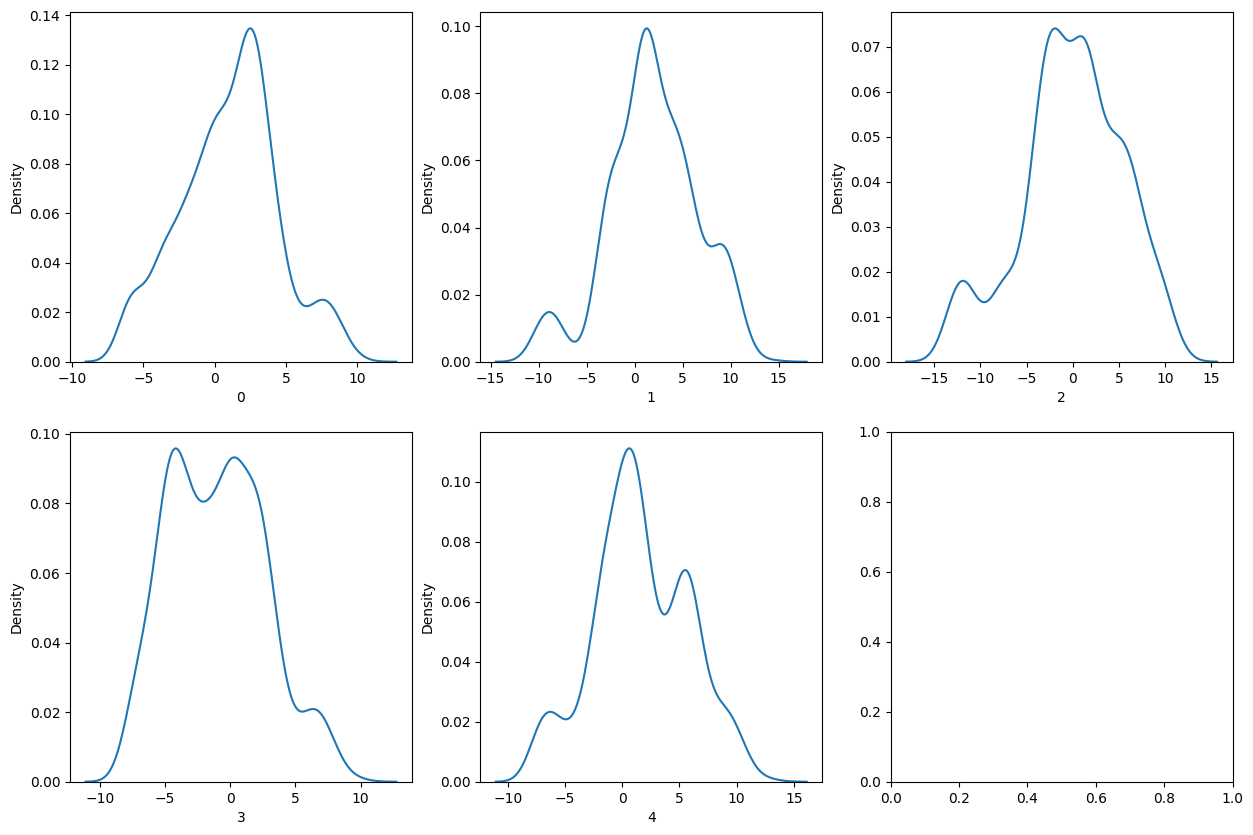

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(5):
    row = i % 3
    col = i // 3
    sns.kdeplot(df, x=(str)(i), ax=ax[col][row])

Отскейлим данные

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler =  StandardScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)

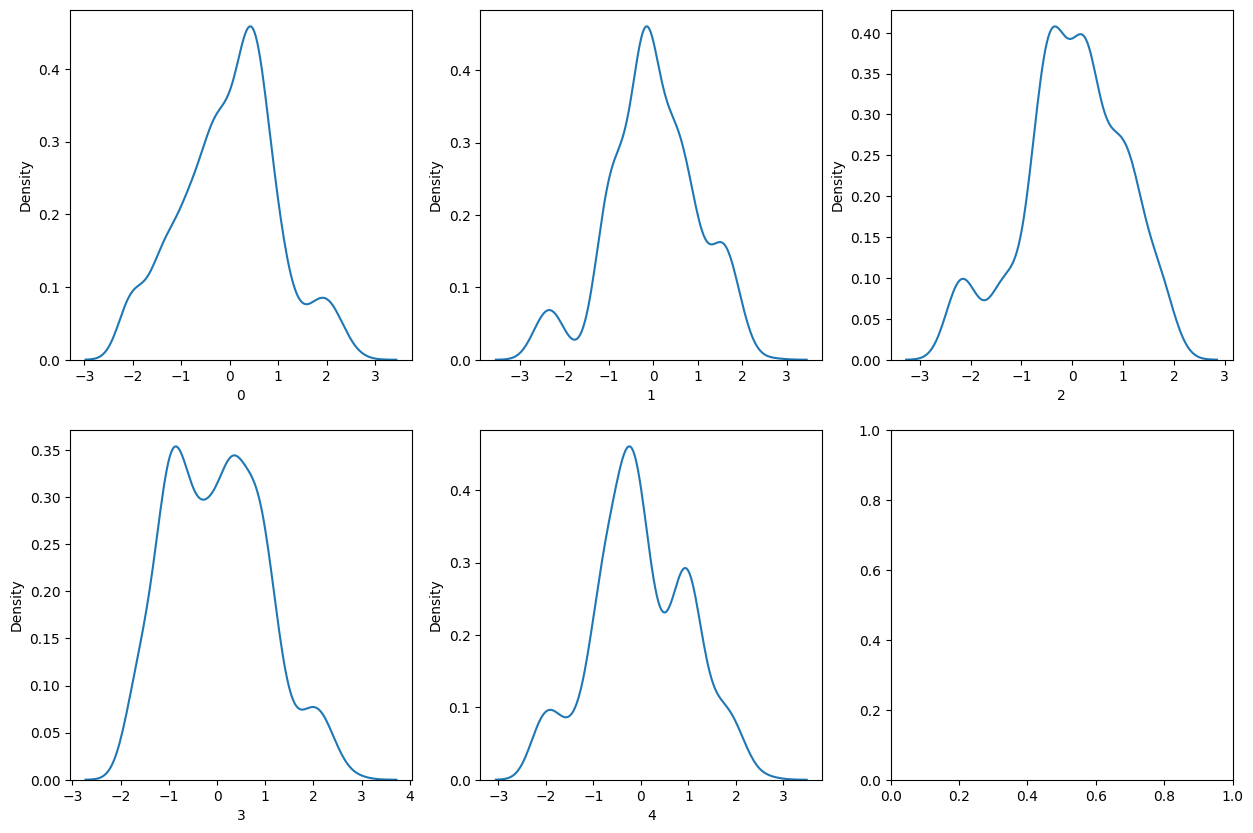

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(5):
    row = i % 3
    col = i // 3
    sns.kdeplot(df_scaled, x=(str)(i), ax=ax[col][row])

Посмотрим корреляцию в данных, возможно какие-то колонки можно дропнуть

<AxesSubplot:>

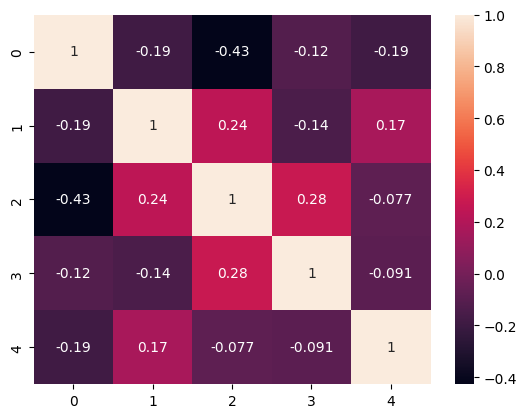

In [12]:
sns.heatmap(df.corr(), annot=True)

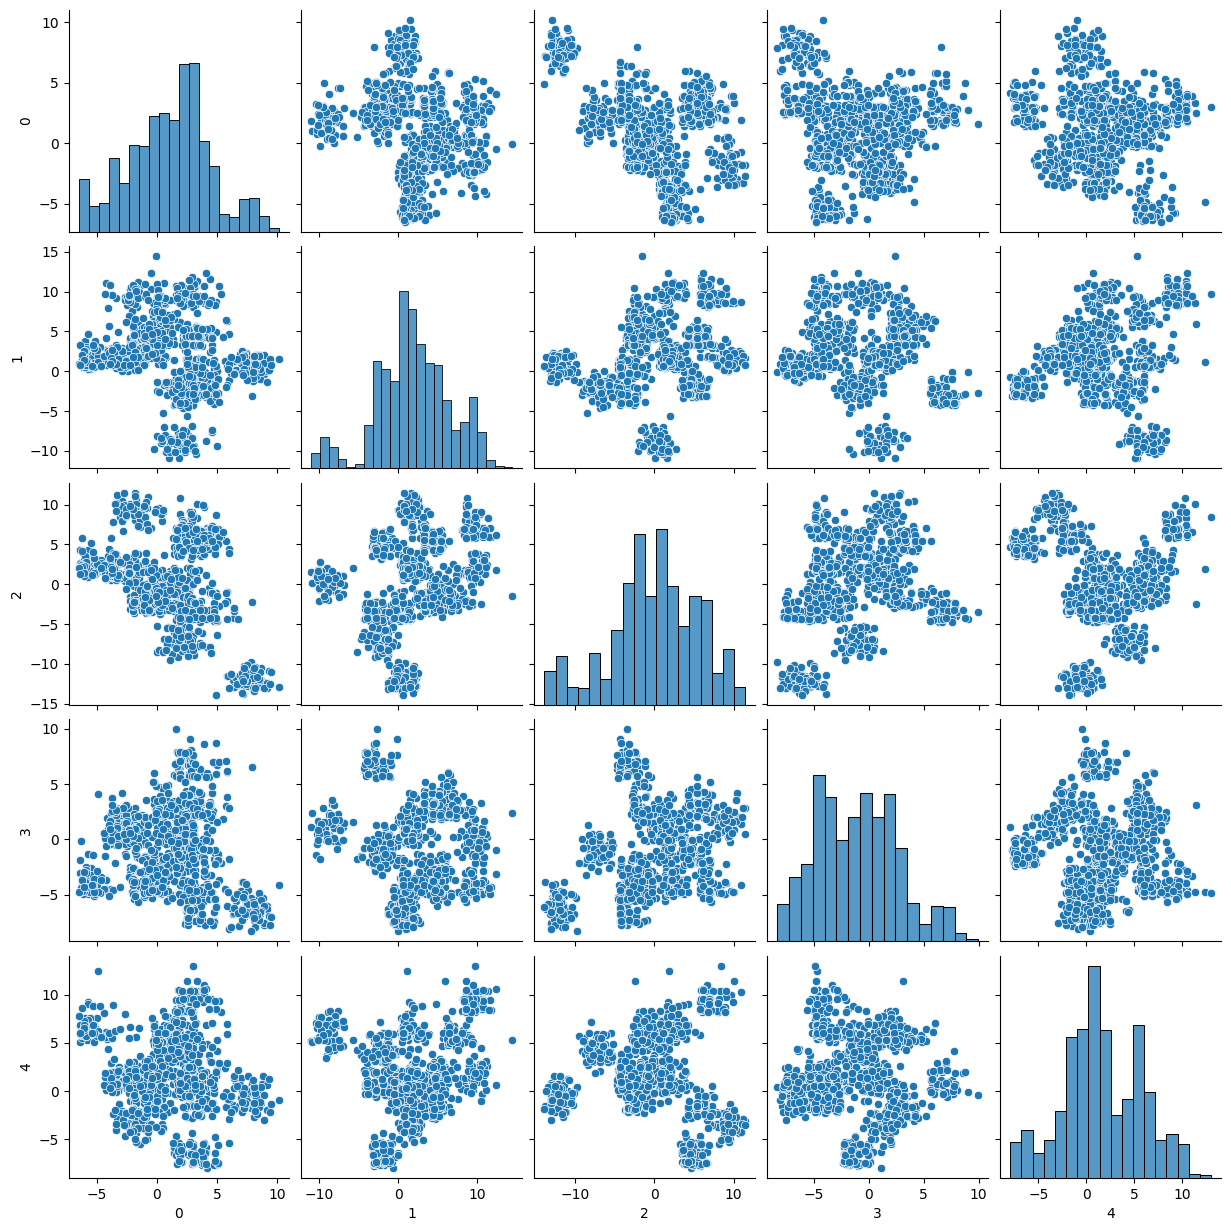

In [13]:
sns.pairplot(df)

# Выполнение задания

Кластеризатор

In [14]:
# !pip install tqdm
# !pip install --upgrade jupyter ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [15]:
#Вспомогательная функция
def plot_with_min_value(X, y):
    plt.plot(X, y)
    y_min = min(y)
    y_min_idx = y.index(y_min)
    X_min = X[y_min_idx]

    plt.scatter(X_min, y_min, color='red')
    plt.annotate(X_min, (X_min, y_min), textcoords="offset points", xytext=(0,10), ha='center')
    print(f'(X_min, y_min): ({X_min}, {y_min})')

Теперь реализуем Agglomerative Clustering

In [16]:
from copy import deepcopy
import numpy as np
import pickle 
from tqdm.notebook import tqdm, trange

In [17]:
class AgglomerativeClusterer:
    def __init__(self, min_k=2, max_k=20, linkage='single'):
        self.linkage = linkage
        self.variances = []
        self.min_k = min_k
        self.max_k = max_k
        self.best_variance = np.inf

    def fit(self, X):
        self.X = X
        self.n_samples = X.shape[0]

        self.clusters = [[i] for i in range(self.n_samples)]
        self._init_distance_matrix()

        bar = tqdm(range(self.n_samples, self.min_k-1, -1))
        bar.set_description('Reducing clusters')

        for k in bar:
            cluster_a, cluster_b = self._find_closest_clusters()
            self._merge_clusters(cluster_a, cluster_b)

            var = self._calculate_inner_variance()
            if var < self.best_variance and k <= self.max_k:
                print(f'new best variance is {var} on k={k}')
                self.best_k = k
                self.best_variance = var
                self.best_model = deepcopy(self)

        return self

    def _vector_dist(self, a, b):
        return np.linalg.norm(a[:, None, :] - b[None, :, :], axis=2)

    def _init_distance_matrix(self):
        n = self.n_samples
        self.distance_matrix = np.full((n, n), np.inf)
        bar = tqdm(range(n))
        bar.set_description('Initializing distances')

        for i in bar:
            for j in range(i + 1, n):
                self.distance_matrix[i, j] = self.distance_matrix[j, i] = self._calculate_distance(self.clusters[i], self.clusters[j])

    def _calculate_distance(self, a, b):
        vec_a = self.X[a]
        vec_b = self.X[b]

        if self.linkage == 'single':
            return np.min(self._vector_dist(vec_a, vec_b))
        elif self.linkage == 'complete':
            return np.max(self._vector_dist(vec_a, vec_b))
        else:
            raise ValueError("Invalid linkage")

    def _find_closest_clusters(self):
        return np.unravel_index(np.argmin(self.distance_matrix), self.distance_matrix.shape)

    def _merge_clusters(self, a, b):
        self.clusters[a] = self.clusters[a] + self.clusters[b]
        self.clusters.pop(b)

        self.distance_matrix = np.delete(self.distance_matrix, b, axis=0)
        self.distance_matrix = np.delete(self.distance_matrix, b, axis=1)

        for i in range(len(self.clusters)):
            if i != a:
                self.distance_matrix[a, i] = self.distance_matrix[i, a] = self._calculate_distance(self.clusters[a], self.clusters[i])
    
    def _calculate_inner_variance(self):
        var = []
        for cluster in self.clusters:
            points = self.X[cluster]
            if points.shape[0] > 1:
                var.append(np.var(points, axis=0).sum())
            else:
                var.append(0)
        
        var_sum = sum(var)
        self.variances.append(var_sum)

        return var_sum


### Метод ближних соседей

In [18]:
clusterer = AgglomerativeClusterer(linkage='single', max_k=50)
clusterer.fit(df_scaled.to_numpy())

labels = np.empty(clusterer.best_model.n_samples, dtype=int)

for cluster_idx, cluster in enumerate(clusterer.best_model.clusters):
    for sample_idx in cluster:
        labels[sample_idx] = cluster_idx

file = open('lables_single', 'wb')
pickle.dump(labels, file)
file.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

new best variance is 4.436226286180667 on k=50


(X_min, y_min): (190, 3.504560516745661)


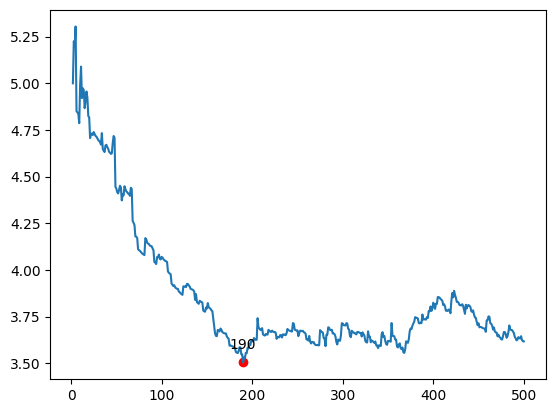

In [19]:
plot_with_min_value(range(clusterer.n_samples, clusterer.min_k-1, -1)[500:], clusterer.variances[500:])

По графику выше видно, что n дающее наиченьшую дисперсию равно 190

Text(0.5, 0.98, 'Custom single')

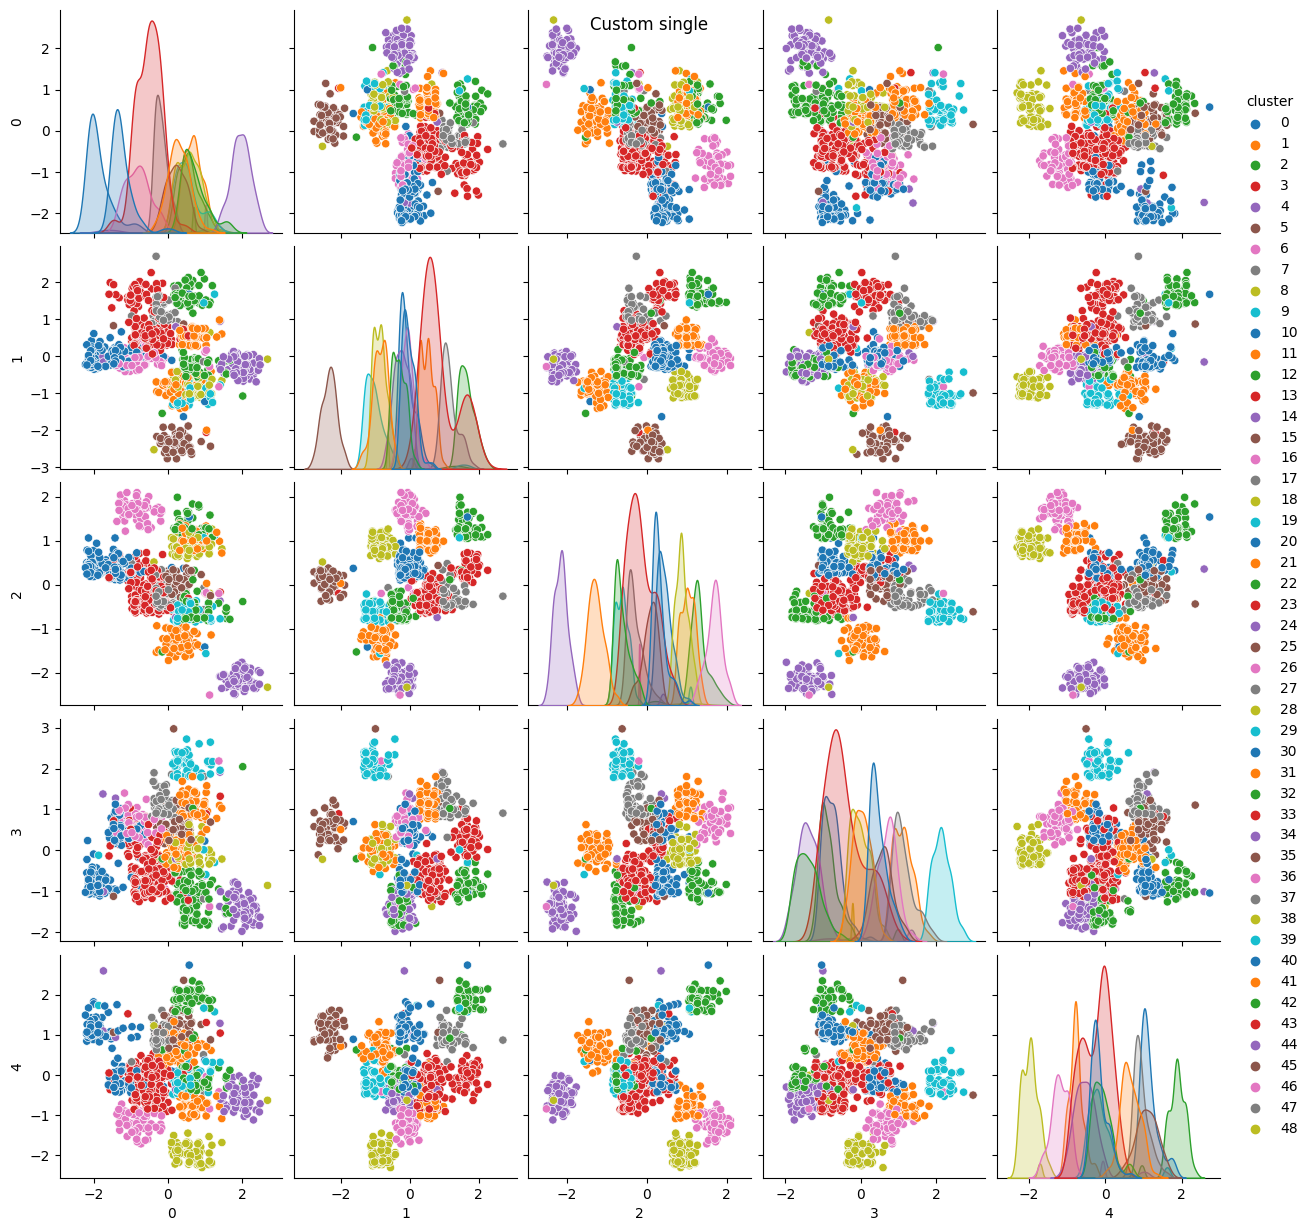

In [20]:
file = open('lables_single', 'rb')
lables = pickle.load(file)
file.close()

clustered_nearest_df = df_scaled.copy()
clustered_nearest_df['cluster'] = labels

g = sns.pairplot(clustered_nearest_df, hue='cluster', palette='tab10')
g.figure.suptitle('Custom single')

Визульно разделение произошло нормально

<AxesSubplot:ylabel='Count'>

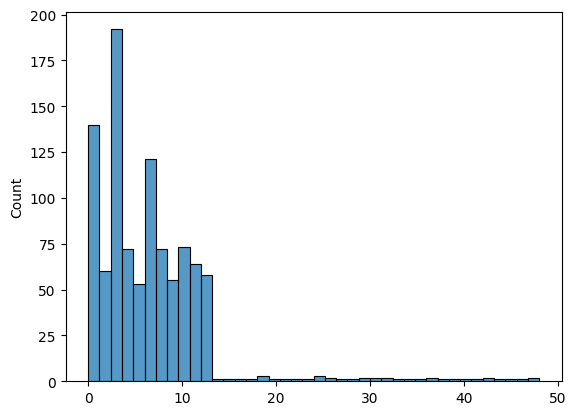

In [21]:
sns.histplot(labels)

А вот тут проблема, размеры кластеров наспределены неравномерно

### Метод дальних соседей

In [22]:
clusterer = AgglomerativeClusterer(linkage='complete', max_k=50)
clusterer.fit(df_scaled.to_numpy())

labels = np.empty(clusterer.best_model.n_samples, dtype=int)
for cluster_idx, cluster in enumerate(clusterer.best_model.clusters):
    for sample_idx in cluster:
        labels[sample_idx] = cluster_idx

file = open('lables_complete', 'wb')
pickle.dump(labels, file)
file.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

new best variance is 9.470187953035762 on k=50
new best variance is 9.425313510765406 on k=49
new best variance is 9.289752813655213 on k=48
new best variance is 9.153206428205193 on k=47
new best variance is 9.042767641689652 on k=46
new best variance is 8.933438832261615 on k=45
new best variance is 8.726569198605379 on k=44
new best variance is 8.557689599825245 on k=43
new best variance is 8.344437851894218 on k=42
new best variance is 8.16150930367536 on k=41
new best variance is 8.038167810777122 on k=40
new best variance is 7.916429620295179 on k=39
new best variance is 7.733788523356315 on k=38
new best variance is 7.553231922156234 on k=37
new best variance is 7.407714210958316 on k=36
new best variance is 7.287506221855328 on k=35
new best variance is 7.022168930871021 on k=34
new best variance is 6.8802794423287255 on k=33
new best variance is 6.684954990252957 on k=32
new best variance is 6.41504610785949 on k=31
new best variance is 6.318519558515283 on k=24
new best varia

(X_min, y_min): (15, 4.673319473374459)


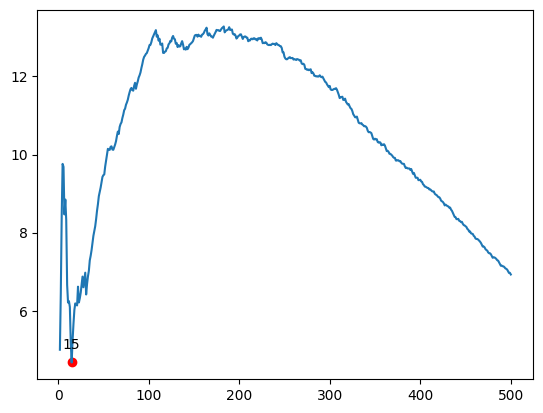

In [23]:
plot_with_min_value(range(clusterer.n_samples, clusterer.min_k-1, -1)[500:], clusterer.variances[500:])

Для метода дальних соседей оптимальное n сильно меньше, чем для метода ближних соседей. Если увеличить максимальное количество кластеров, то мы найдем значение с меньшей дисперсией, но будет абсурдно большое колличество кластером

Text(0.5, 0.98, 'Custom complete')

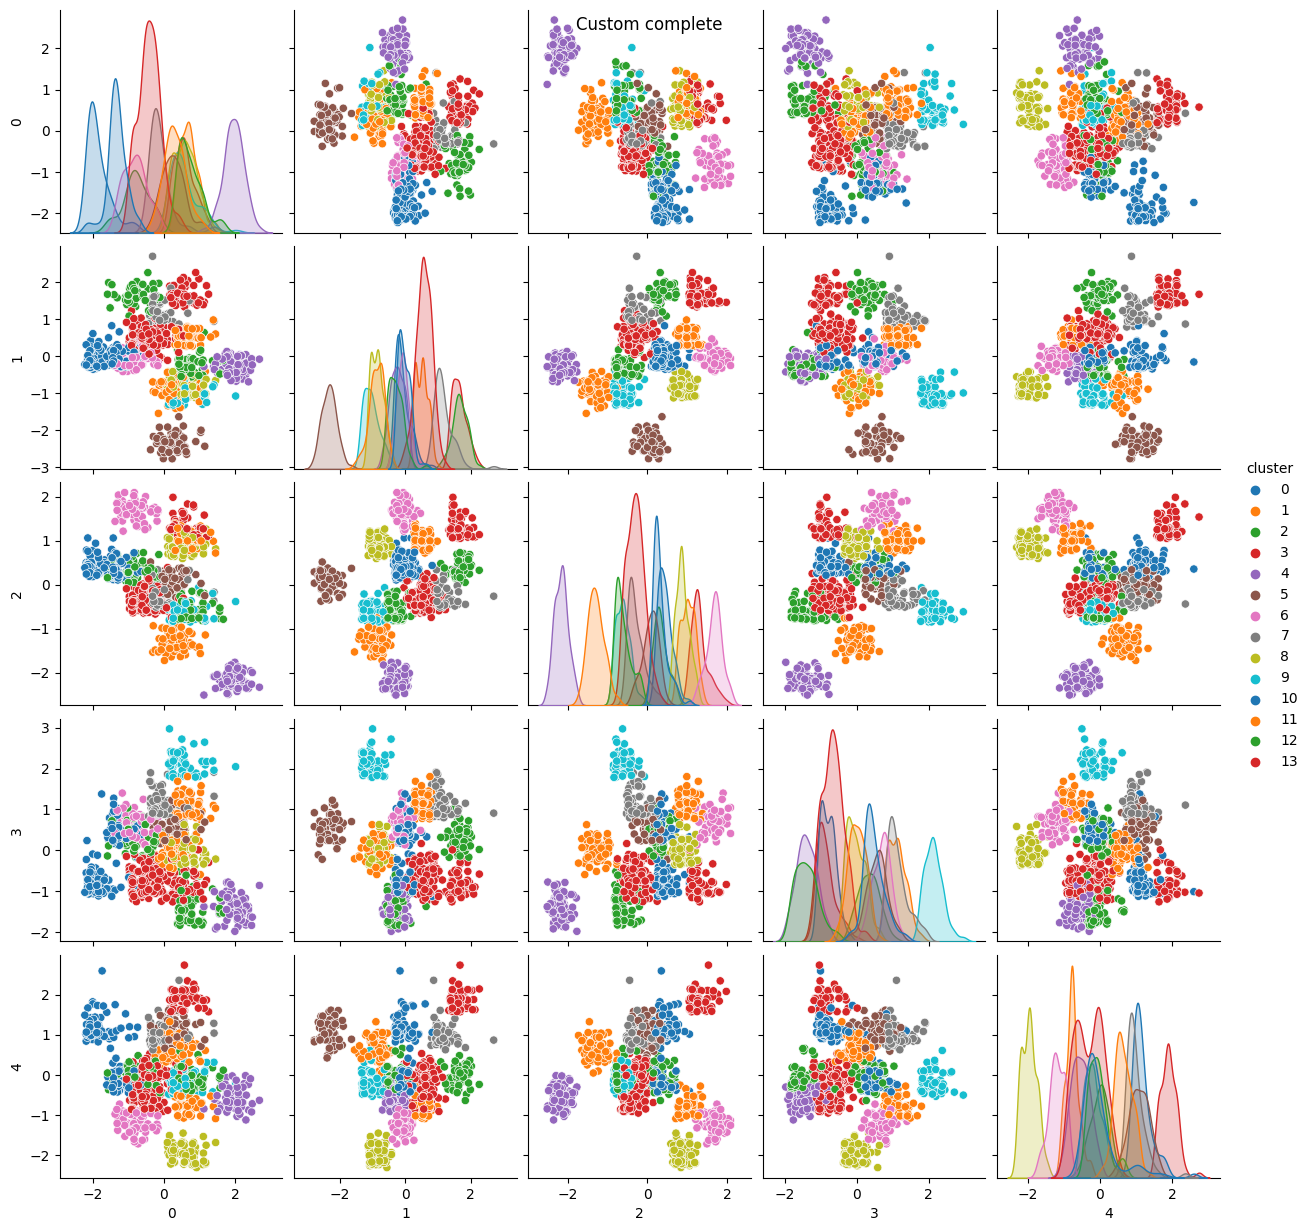

In [24]:
file = open('lables_complete', 'rb')
load = pickle.load(file)
file.close()

clustered_futherest_df = df_scaled.copy()

clustered_futherest_df ['cluster'] = labels

g = sns.pairplot(clustered_futherest_df, hue='cluster', palette='tab10')
g.figure.suptitle('Custom complete')

Визуально кластеризация прошла хорошо

<AxesSubplot:ylabel='Count'>

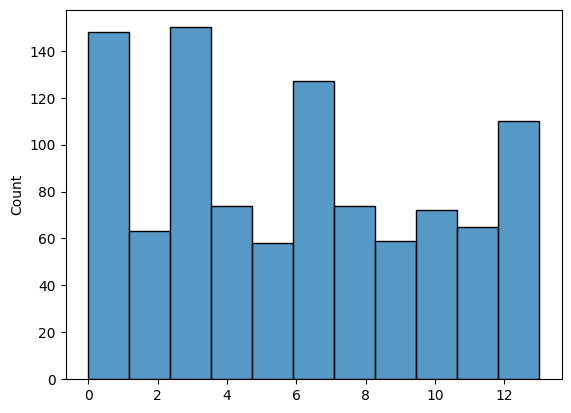

In [25]:
sns.histplot(labels)

И с распределением по кластерам все сильно лучше чем в методе ближних соседей

### Определение распределений

Возьмем данные, полученные при кластеризации методом дальних соседей и определим распределение в каждом кластере при помощи теста Колмагорова-Смирнова

In [66]:
from scipy import stats


distributions = {
    "Normal": stats.norm,
    "Logistic": stats.logistic,
    "Lognormal": stats.lognorm,
    "Exponential": stats.expon,
    "Weibull": stats.weibull_min,
    "Gamma": stats.gamma,
    "Uniform": stats.uniform,
    "Beta": stats.beta,
    "Cauchy": stats.cauchy,
    "Student's t": stats.t,
    "Pareto": stats.pareto,
    "Gumbel": stats.gumbel_r,
    "Rayleigh": stats.rayleigh,
    "Chi-Squared": stats.chi2,
    "F Distribution": stats.f,
    "Beta Prime": stats.betaprime,
    "Laplace": stats.laplace,
    "Johnson SU": stats.johnsonsu,
    "GEV": stats.genextreme,
    "Generalized Gamma": stats.gengamma,
    "Inverse Gaussian": stats.invgamma,
    "Triangular": stats.triang,
    "Half-Normal": stats.halfnorm
}

def get_best_distribution_by_column(data):
    for col in data.columns:
        column_data = data[col].values
        results = {}
        
        for name, dist in distributions.items():
            params = dist.fit(column_data)
            _, p_value = stats.kstest(column_data, dist.cdf, args=params)
            results[name] = {'p': p_value, 'params': params}
        
        results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1]['p'])}
            
        best = next(iter(results))
        print(f"best fit for {col}: {best} (p: {results[best]['p']:.2e})")
    

In [67]:
for cluster in set(labels):
    print(f'trying to figure out distribution for lalel {cluster}')
    get_best_distribution_by_column(clustered_futherest_df[clustered_futherest_df.cluster == cluster].drop('cluster', axis=1))
    print(f'\n-----------------------------------------------------\n')

trying to figure out distribution for lalel 0


c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:805: RuntimeWarning: divide by zero encounter

best fit for 0: F Distribution (p: 2.02e-16)
best fit for 1: F Distribution (p: 1.81e-20)
best fit for 2: Uniform (p: 7.39e-17)
best fit for 3: Chi-Squared (p: 4.82e-13)
best fit for 4: Uniform (p: 7.26e-24)

-----------------------------------------------------

trying to figure out distribution for lalel 1
best fit for 0: F Distribution (p: 4.58e-12)
best fit for 1: F Distribution (p: 3.34e-15)
best fit for 2: Chi-Squared (p: 9.99e-10)
best fit for 3: F Distribution (p: 4.48e-15)
best fit for 4: Exponential (p: 1.81e-07)

-----------------------------------------------------

trying to figure out distribution for lalel 2
best fit for 0: Pareto (p: 6.05e-12)
best fit for 1: Pareto (p: 9.16e-18)
best fit for 2: F Distribution (p: 4.84e-18)
best fit for 3: F Distribution (p: 8.72e-12)
best fit for 4: F Distribution (p: 7.48e-15)

-----------------------------------------------------

trying to figure out distribution for lalel 3
best fit for 0: F Distribution (p: 1.68e-12)
best fit for 

c:\Users\mgsds\projects\itmo-math-modelling\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


best fit for 2: Chi-Squared (p: 7.88e-10)
best fit for 3: F Distribution (p: 9.77e-11)
best fit for 4: GEV (p: 5.66e-10)

-----------------------------------------------------

trying to figure out distribution for lalel 6
best fit for 0: Chi-Squared (p: 1.22e-05)
best fit for 1: F Distribution (p: 1.08e-14)
best fit for 2: GEV (p: 5.61e-18)
best fit for 3: Pareto (p: 4.26e-06)
best fit for 4: Pareto (p: 4.38e-10)

-----------------------------------------------------

trying to figure out distribution for lalel 7
best fit for 0: Uniform (p: 3.26e-21)
best fit for 1: Uniform (p: 1.36e-17)
best fit for 2: F Distribution (p: 3.20e-14)
best fit for 3: Uniform (p: 1.50e-07)
best fit for 4: Uniform (p: 7.81e-19)

-----------------------------------------------------

trying to figure out distribution for lalel 8
best fit for 0: Uniform (p: 4.62e-06)
best fit for 1: F Distribution (p: 4.87e-21)
best fit for 2: Chi-Squared (p: 2.35e-11)
best fit for 3: F Distribution (p: 1.79e-17)
best fit fo